# Prep

## Dependencies

In [1]:
# General
import os
from os import path
import shutil
import glob
from datetime import datetime
from tqdm.notebook import tqdm

# Data processing
import pandas as pd
import numpy as np

# Keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# ScikitLearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    auc,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay)

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Images
import cv2

2023-04-23 23:54:08.231168: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 23:54:11.414197: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-04-23 23:54:11.414350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

## Constants

In [16]:
CLASSES = ["normal", "covid"] # In order, first = 0, then 1, etc.
NUM_EPOCHS = 80
VALID_SPLIT = 0.15
LABEL_COLUMN = 'label'
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
RANDOM_STATE = 41
LEARNING_RATE =0.0001
OUT_MODEL_PATH = "./models"

## Prepare Datasets

In [3]:
# Get paths
raw_data_path = path.join(os.getcwd(), "data/four_classes")
train_data_path = path.join(raw_data_path, "train")
test_data_path = path.join(raw_data_path, "test")

In [4]:
def get_image_df(data_path, labels_filter=CLASSES):
    labels = os.listdir(data_path)
    columns = ["image_path", LABEL_COLUMN]
    
    images = []
    for label in labels:
        if label not in labels_filter:
            continue
        label_image_paths = os.listdir(path.join(data_path, label))
        label_images = list(map(lambda im_path: [f"{label}/{im_path}", label], label_image_paths))
        images.extend(label_images)
        
    return pd.DataFrame(images, columns=columns)
        
train_df = get_image_df(train_data_path)
test_df = get_image_df(test_data_path)
display(train_df.sample(5).head())
display(test_df.sample(5).head())

,image_path,label
646,normal/IM-0338-0001.jpeg,normal
214,covid/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg,covid
327,normal/IM-0499-0001-0001.jpeg,normal
263,covid/pneumocystis-jiroveci-pneumonia-4-L.png,covid
226,covid/nejmoa2001191_f3-PA.jpeg,covid


,image_path,label
1,covid/SARS-10.1148rg.242035193-g04mr34g0-Fig8b...,covid
29,normal/IM-0029-0001.jpeg,normal
63,normal/NORMAL2-IM-0354-0001.jpeg,normal
16,covid/figure1-5e7c1b8d98c29ab001275405-98-late...,covid
57,normal/IM-0041-0001.jpeg,normal


In [5]:
# Stratify split test dataset into test and validation
train_df, valid_df = train_test_split(train_df,
                                     test_size=VALID_SPLIT,
                                     shuffle=True,
                                     stratify=train_df[LABEL_COLUMN],
                                     random_state=RANDOM_STATE
                                    )

## Load Dataset

In [6]:
#Train datagen here is a preprocessor
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   # validation_split = 0.2,
                                   fill_mode='constant')


flow_kwargs = {
    # 'directory': train_data_path,
    'x_col': 'image_path',
    'y_col': LABEL_COLUMN,
    'batch_size': BATCH_SIZE,
    'seed': RANDOM_STATE,
    'class_mode': 'categorical',
    'classes': CLASSES,
    'target_size': IMAGE_SIZE
}

#Test Datagen only rescales for model
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_batches = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                  directory=train_data_path, shuffle=True, **flow_kwargs)

valid_batches = train_datagen.flow_from_dataframe(dataframe=valid_df,
                                                  directory=train_data_path, shuffle=False, **flow_kwargs)

test_batches = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_data_path, shuffle=False, **flow_kwargs)

DATASETS = {
    'train': train_batches,
    "validation": valid_batches,
    'test': test_batches,
}

Found 567 validated image filenames belonging to 2 classes.
Found 101 validated image filenames belonging to 2 classes.
Found 97 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1452: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


# EDA

In [7]:
print(train_batches.class_indices)

{'normal': 0, 'covid': 1}


In [8]:
print(f"Train dataset length: {len(train_df)}")
print(f"Valid dataset length: {len(valid_df)}")
print(f"Test dataset length: {len(test_df)}")

Train dataset length: 567
Valid dataset length: 101
Test dataset length: 98


In [9]:
xb, yb = train_batches.next()
xb.shape,yb.shape

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "


((32, 150, 150, 3), (32, 2))

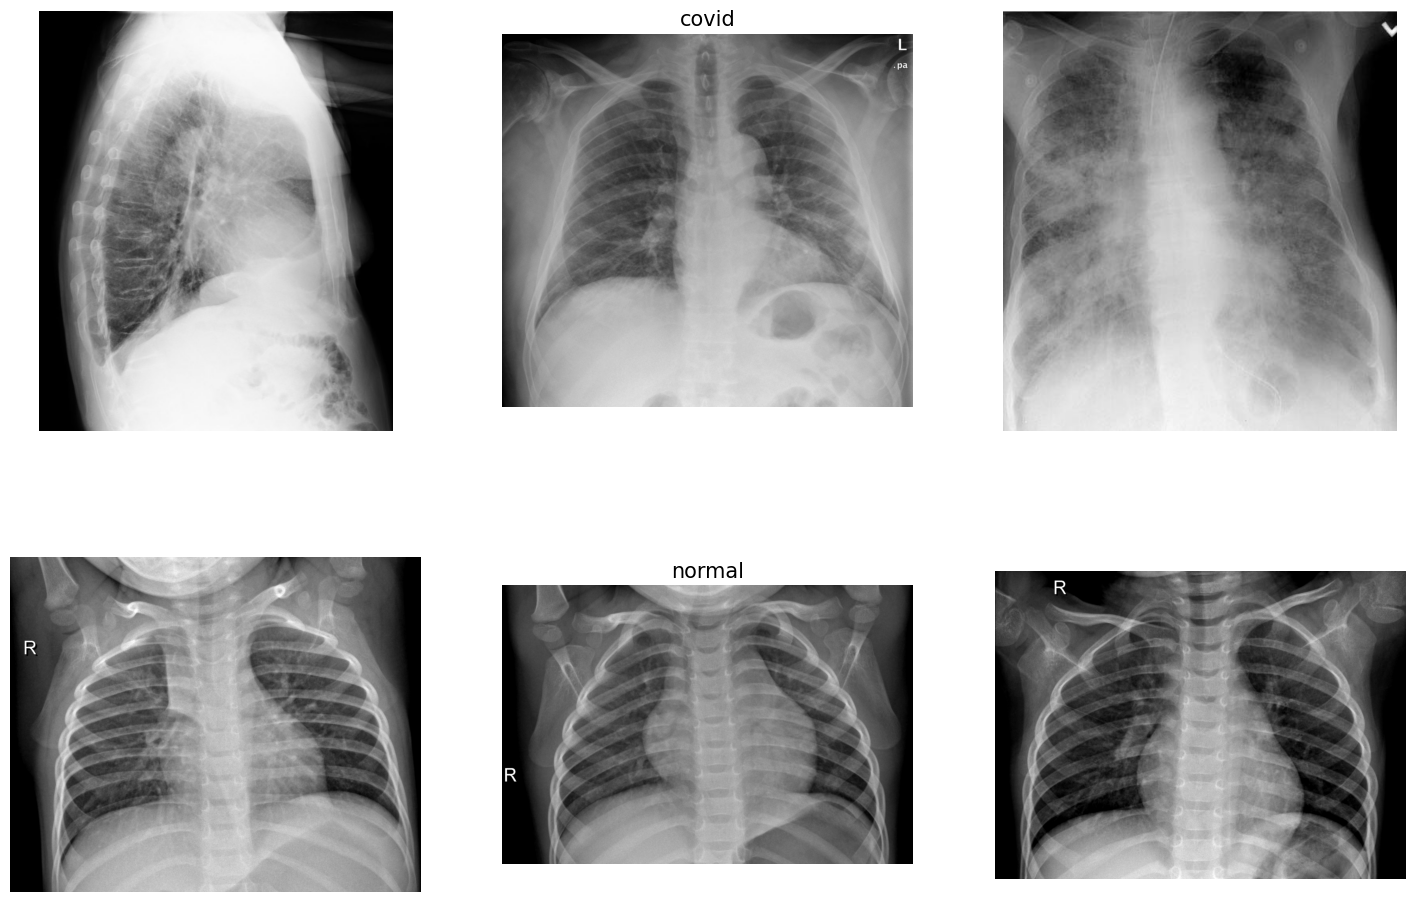

In [10]:
def display_class_sample(df, data_path, num_samples_per_class=3, middle_image=1):
    fig, axs = plt.subplots(2, num_samples_per_class, figsize = (6*num_samples_per_class, 3*4))

    for ax_row, (label, data) in zip(axs, df.sort_values([LABEL_COLUMN]).groupby(LABEL_COLUMN)):
        ax_row[middle_image].set_title(label, fontsize = 15)
        for ax, (idx, instance) in zip(ax_row, data.sample(num_samples_per_class).iterrows()):       
            _path = path.join(data_path, instance['image_path'])
            image = cv2.imread(_path)
            ax.imshow(image)
            ax.axis('off')

display_class_sample(train_df, train_data_path)

# Train Model

## Build CoroNet (Xception with additional layers)

In [11]:
def build_model(summary=True):
    conv_base = tf.keras.applications.Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

    conv_base.trainable = True

    model = tf.keras.models.Sequential()
    model.add(conv_base)

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(len(CLASSES), activation=None))
    # model.add(layers.Dense(len(CLASSES), activation='softmax'))

    model.build()

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
                  metrics=['accuracy'])
    if summary:
        print(model.summary())
        
    return model

In [12]:
model = build_model(summary=True)

2023-04-23 23:54:18.381530: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-23 23:54:18.381617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (expensive): /proc/driver/nvidia/version does not exist
2023-04-23 23:54:18.382477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________
None


## Fit Model

In [13]:
def train_model_and_save_results(*args, out_path=OUT_MODEL_PATH, save_final=True, **kwargs):
    out_path = path.join(out_path, datetime.now().isoformat())
    os.makedirs(out_path, exist_ok=True)
    
    save_model = tf.keras.callbacks.ModelCheckpoint(
        f"{out_path}/"+"{epoch:04d}-{accuracy:.2f}.tf",
        monitor = "val_loss",
        mode='min',
        verbose=0,
        save_weights_only=True,
        save_best_only=True
    )
    callbacks=kwargs.pop("callbacks", [])

    history = model.fit(callbacks=[*callbacks, save_model], *args, **kwargs)
    np.save(path.join(out_path, "history.npy"), history.history)
    
    # Save final model
    last_accuracy = history.history['accuracy'][-1]
    final_out_path = f"{out_path}/" + "last-{accuracy:.2f}.tf".format(accuracy=last_accuracy)
    model.save_weights(final_out_path)
    
    return history.history

In [17]:
LOAD_MODEL = False

# best_checkpoint = path.join(OUT_MODEL_PATH, "./2023-04-23T12:44:51.561936", "0075-0.97.tf")
    
if LOAD_MODEL:
    model_path = path.join(OUT_MODEL_PATH, "./2023-04-23T14:55:23.665077")
    checkpoint_path = path.join(model_path, "0079-1.00.tf")
    history_path = path.join(model_path, "history.npy")
    model.load_weights(checkpoint_path)
    history = np.load(history_path, allow_pickle='TRUE').item()
else:
    history = train_model_and_save_results(train_batches,
                                 validation_data=valid_batches,
                                 epochs=NUM_EPOCHS,
                                 workers=1,)
                                 # class_weight=class_weights)

Epoch 1/80
18/18 [==============================] - 77s 4s/step - loss: 0.0897 - accuracy: 0.9718 - val_loss: 0.1028 - val_accuracy: 0.9703
Epoch 2/80
18/18 [==============================] - 71s 4s/step - loss: 0.0654 - accuracy: 0.9753 - val_loss: 0.1119 - val_accuracy: 0.9802
Epoch 3/80
18/18 [==============================] - 71s 4s/step - loss: 0.0630 - accuracy: 0.9806 - val_loss: 9.1857e-04 - val_accuracy: 1.0000
Epoch 4/80
18/18 [==============================] - 77s 4s/step - loss: 0.1027 - accuracy: 0.9683 - val_loss: 0.1543 - val_accuracy: 0.9802
Epoch 5/80
18/18 [==============================] - 70s 4s/step - loss: 0.0485 - accuracy: 0.9824 - val_loss: 0.0857 - val_accuracy: 0.9703
Epoch 6/80
18/18 [==============================] - 71s 4s/step - loss: 0.0386 - accuracy: 0.9859 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 7/80
18/18 [==============================] - 72s 4s/step - loss: 0.0260 - accuracy: 0.9947 - val_loss: 0.0152 - val_accuracy: 0.9901
Epoch 8/80
18/18

# Evaluate

In [66]:
def get_pred_and_truth_not_shuffled(model, batches, single_binary_neuron=False):
    """
    This can only be used if the dataset is not shuffled
    """
    preds = model.predict(batches)
    if single_binary_neuron:
        # For single neuron with binary class probabily output
        y_pred = np.where(preds > 0.5, 1, 0)
    else:
        # For multi class or binary class using 2 neurons
        y_pred = np.argmax(preds, axis=-1)
    y_true = batches.classes
    return y_pred, y_true


def get_pred_and_truth(model, batches, single_binary_neuron=False):
    """
    This is required if the dataset is shuffled. You can't use batches.classes as the indexes are all wrong.
    Instead you get each batch, one at a time and process 
    """
    
    batches.reset()
    y_pred_batches = []  # store predicted labels
    y_true_batches = []  # store true labels
    
    for idx in tqdm(range(len(batches))):
        img_batch, y_batch = batches[idx]
        
        preds_batch = model.predict(img_batch, verbose=0)
        
        if single_binary_neuron:
            # For single neuron with binary class probabily output
            y_pred_batch = np.where(preds_batch > 0.5, 1, 0)
        else:
            # For multi class or binary class using 2 neurons
            y_pred_batch = np.argmax(preds_batch, axis=-1)
            
        y_true_batch = np.argmax(y_batch,-1)
        
        
        y_pred_batches.append(y_pred_batch)
        y_true_batches.append(y_true_batch)

    y_true = tf.concat([item for item in y_true_batches], axis = 0)
    y_pred = tf.concat([item for item in y_pred_batches], axis = 0)
    
    return y_pred, y_true

def evaluate_metrics(name, y_pred, y_true, round_to=6, plot=True):
    # Get confusion matrix and standard metrics for display in dataframe
    # Metrics calculated with Sklearn where possible
    cm = confusion_matrix(y_true, y_pred)
    conf = ConfusionMatrixDisplay(cm)
    specificity = round((cm[0,0]/(cm[0,0] + cm[0,1])),round_to)
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name)
    
    metrics = []
    metrics.append(["Accuracy", round(accuracy_score(y_true, y_pred),round_to)]) 
    metrics.append(["Recall", round(recall_score(y_true, y_pred),round_to)]) # TP/P
    metrics.append(["Specificity", specificity]) # TN/N
    metrics.append(["Precision", round(precision_score(y_true, y_pred),round_to)]) # TP/TP+FP
    metrics.append(["F1 Score", round(f1_score(y_true, y_pred),round_to)]) # 2 * (precision + recall) / (precison * recall)
    metrics = pd.DataFrame(data=metrics, columns=["Metric", "Score"])

    if plot:
        print(f"\n----------------------------- Classification report for {name} dataset -----------------------------\n")
        display(metrics)
        conf.plot()
        plt.show()
        roc.plot()
        plt.show()
        
    return metrics, conf

def evaluate_on_dataset(model, dataset, dataset_name, plot=True):
    y_pred, y_true = get_pred_and_truth(model, dataset)
    return evaluate_metrics(dataset_name, y_pred, y_true, plot=plot)

def evaluate_on_all_datasets(model, datasets=DATASETS):
    for name, d in datasets.items():
        metrics, conf = evaluate_on_dataset(model, d, name, plot=True)

def plot_loss_accuracy_curves(history, plot=True, limit_epochs=None):
    """
    Takes history.history
    """
    fig, axes = plt.subplots(1, 2, figsize=(16,8))

    
    for metric, ax in zip(['loss', 'accuracy'], axes):
        if not limit_epochs:
            limit_epochs = len(history[metric])
        ax.plot(history[metric][:limit_epochs])
        ax.plot(history[f'val_{metric}'][:limit_epochs])
        ax.set_title(f'model {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'val'], loc='upper left')
    plt.show()

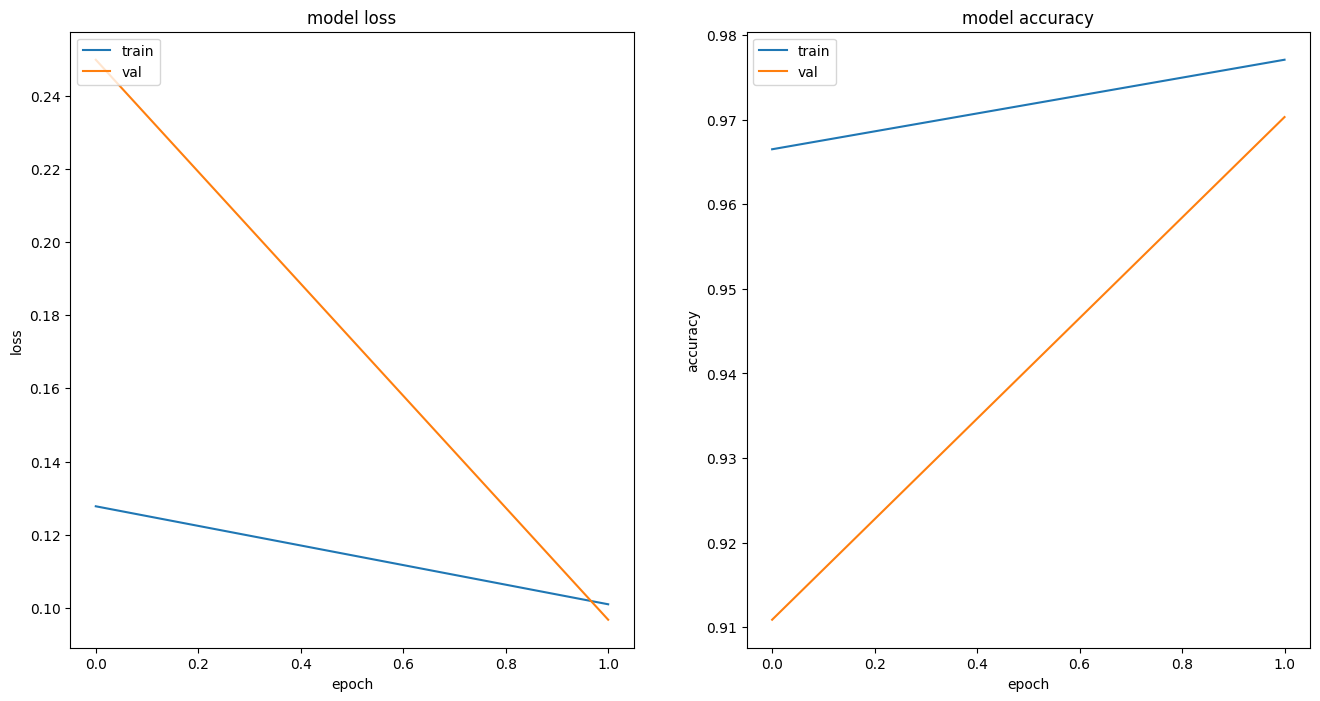

In [68]:
plot_loss_accuracy_curves(history, plot=True)

  0%|          | 0/18 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "



----------------------------- Classification report for train dataset -----------------------------



,Metric,Score
0,Accuracy,0.975309
1,Recall,0.945098
2,Specificity,1.000000
3,Precision,1.000000
4,F1 Score,0.971774


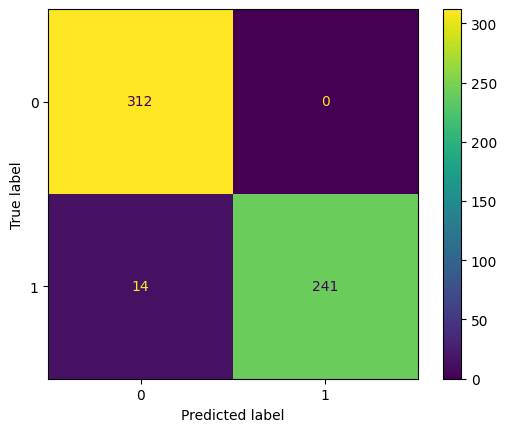

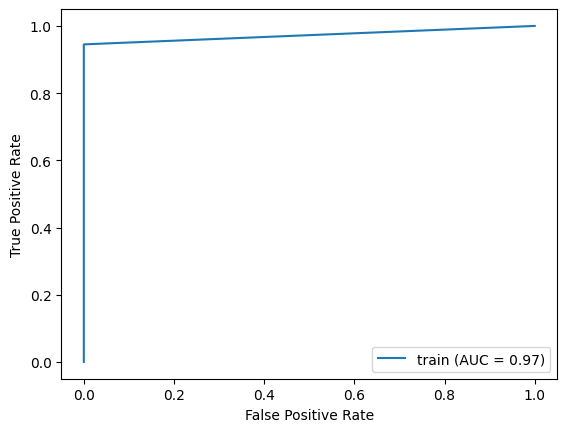

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "
/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  "This ImageDataGenerator specifies "



----------------------------- Classification report for validation dataset -----------------------------



,Metric,Score
0,Accuracy,0.990099
1,Recall,0.977778
2,Specificity,1.000000
3,Precision,1.000000
4,F1 Score,0.988764


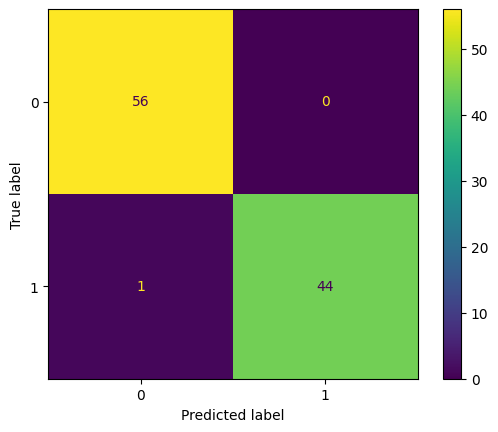

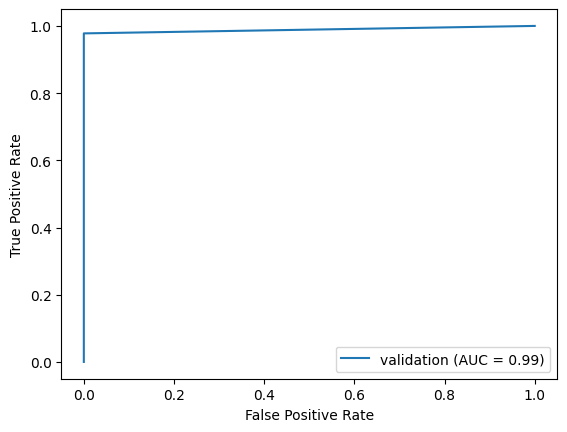

  0%|          | 0/4 [00:00<?, ?it/s]


----------------------------- Classification report for test dataset -----------------------------



,Metric,Score
0,Accuracy,0.979381
1,Recall,0.950000
2,Specificity,0.987013
3,Precision,0.950000
4,F1 Score,0.950000


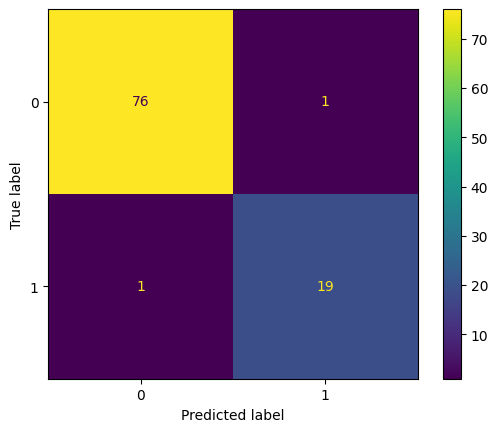

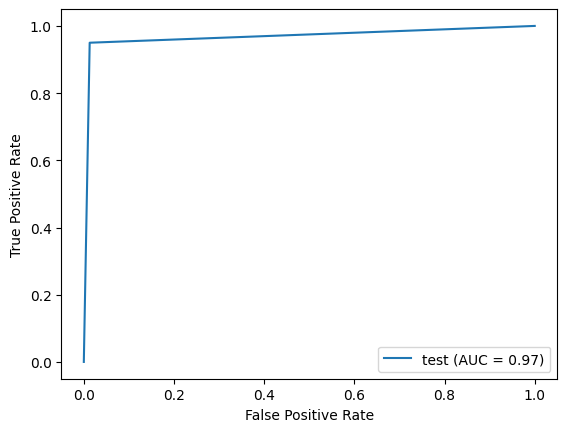

In [71]:
evaluate_on_all_datasets(model)